<a href="https://colab.research.google.com/github/ruslanbakin/classification-of-the-color-image/blob/main/Flowers_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом блокноте, вам предстоит классифицировать изображения цветов. Для создания классификатора изображений, вы можете используя модель `tf.keras.Sequential`, а для загрузки данных --`tf.keras.preprocessing.image.ImageDataGenerator.`

**Импорт пакетов**


Начнем с импорта необходимых пакетов. Пакет `os` используется для чтения файлов и структуры каталогов, `numpy` используется для преобразования списка `Python` в массив `numpy` для дальнейшего выполнения необходимых матричных операций, а matplotlib.pyplot используется для визаулизации исходных данных и результатов обучения.

In [ ]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt


**Что нужно сделать:**

В ячейке ниже импортируйте `Tensorflow` как `tf`, а также слои и модели `Keras`, которые вы будете использовать для создания CNN. Кроме того, импортируйте `ImageDataGenerator` из `Keras`, чтобы было можно преобразовывать изображения.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

#Dense() – полносвязный слой;
#Conv1D, Conv2D, Conv3D – сверточные слои;
#Conv2DTranspose, Conv3DTranspose – транспонированные (обратные) светочные слои;
#SimpleRNN, LSTM, GRU – рекуррентные слои;
#MaxPooling2D, Dropout, BatchNormalization – вспомогательныеслои



**Загрузка данных**

Создание классификатора изображений мы начнем с загрузки набора данных содержащего фотографии цветов. Сначала нам нужно загрузить архивную версию набора данных и сохранить ее в каталоге `/tmp/`. После загрузки набора данных нам необходимо извлечь его содержимое.

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


228813984/228813984 [==============================] - 12s 0us/step


Загруженный набор данных содержит изображения пяти типов цветов:

Роза

Маргаритка

Одуванчик

Подсолнух

Тюльпан

Давайте создадим метки для этих пяти классов:

In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']


Кроме того, загруженный набор данных имеет следующую структуру каталогов.

Кроме того, загруженный набор данных имеет следующую структуру каталогов:
```
flower_photos
|__ daisy
|__ dandelion
|__ roses
|__ sunflowers
|__ tulips
```
Как вы можете видить, здесь нет разбиения данных на обучающие и проверочные. Поэтому нам придется создать собственные наборы для обучения и проверки.
Код ниже создает папку train и val, каждая из которых содержит 5 папок (по одной для каждого типа цветов). Затем он перемещает изображения из исходных папок в эти новые папки, так что 80% изображений попадают в обучающий набор, а 20% изображений — в проверочный набор. В итоге наш каталог будет иметь следующую структуру:
```
flower_photos
|__ daisy
|__ dandelion
|__ roses
|__ sunflowers
|__ tulips
|__ train
    |______ daisy: [1.jpg, 2.jpg, 3.jpg ....]
    |______ dandelion: [1.jpg, 2.jpg, 3.jpg ....]
    |______ roses: [1.jpg, 2.jpg, 3.jpg ....]
    |______ sunflowers: [1.jpg, 2.jpg, 3.jpg ....]
    |______ tulips: [1.jpg, 2.jpg, 3.jpg ....]
|__ val
    |______ daisy: [507.jpg, 508.jpg, 509.jpg ....]
    |______ dandelion: [719.jpg, 720.jpg, 721.jpg ....]
    |______ roses: [514.jpg, 515.jpg, 516.jpg ....]
    |______ sunflowers: [560.jpg, 561.jpg, 562.jpg .....]
    |______ tulips: [640.jpg, 641.jpg, 642.jpg ....]# Выбран кодовый формат
```
Поскольку мы не удаляем исходные папки, они все равно останутся в нашем каталоге flowers_photos, но будут пустыми. Код ниже также выводит общее количество изображений цветов, которые у нас есть для каждого типа цветов.

In [ ]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))


roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


Для удобства, давайте настроем пути для наборов обучения и проверки.

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


**Дополнение данных**

Переобучение обычно происходит, когда у нас мало обучающих примеров. Один из способов решить эту проблему — расширить наш набор данных, чтобы в нем было достаточное количество обучающих примеров. При дополнении данных используется подход, заключающийся в создании большего количества обучающих данных из существующих обучающих выборок путем расширения выборок с помощью ряда случайных преобразований, которые позволяют получить правдоподобные синтетические данные. Цель состоит в том, чтобы во время обучения модель никогда не видела одну и ту же картинку дважды. Это позволяет модели увидеть большее количество аспектов данных и лучше обобщить эти данные.
В `tf.keras` мы можем реализовать этот процесс, используя тот же класс `ImageDataGenerator`, который мы использовали ранее. Мы можем передать преобразования, которые нам нужны, в виде аргументов `ImageDataGenerator`, и он позаботится о их применении к набору данных во время процесса обучения.

**Эксперименты с различными преобразованиями изображений**

В этом разделе вы попрактикуетесь в выполнении некоторых основных преобразований изображений. Но перед этим, нужно определить размер пакета и размер изображения. Помните, что входными данными для CNN являются изображения одного и того же размера. Поэтому нам необходимо привести размер изображений в нашем обучающем наборе данных к одному значению.

**Что нужно сделать:**

В ячейке ниже определите размер пакета в 100 изображений и установите значение `IMG_SHAPE`, так чтобы обучающие данные состояли из изображений шириной 150 пикселей и высотой 150 пикселей.

In [ ]:
batch_size = 100
IMG_SHAPE = 150


**Что нужно сделать:**

В ячейке ниже используйте `ImageDataGenerator`, чтобы создать преобразование, которое масштабирует изображения, а затем применяет случайное горизонтальное отражение. Затем используйте метод `.flow_from_directory`, чтобы применить вышеуказанное преобразование к изображениям в обучающем наборе. Обязательно укажите размер пакета, путь к каталогу обучающих изображений, целевой размер изображений и перемешайте изображения.

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='sparse')



Found 2935 images belonging to 5 classes.


Давайте возьмем одио изображение из наших обучающих примеров и повторим его пять раз, чтобы можно было увидеть результаты применения модификации этого вида к одному и тому же изображению пять раз случайным образом.

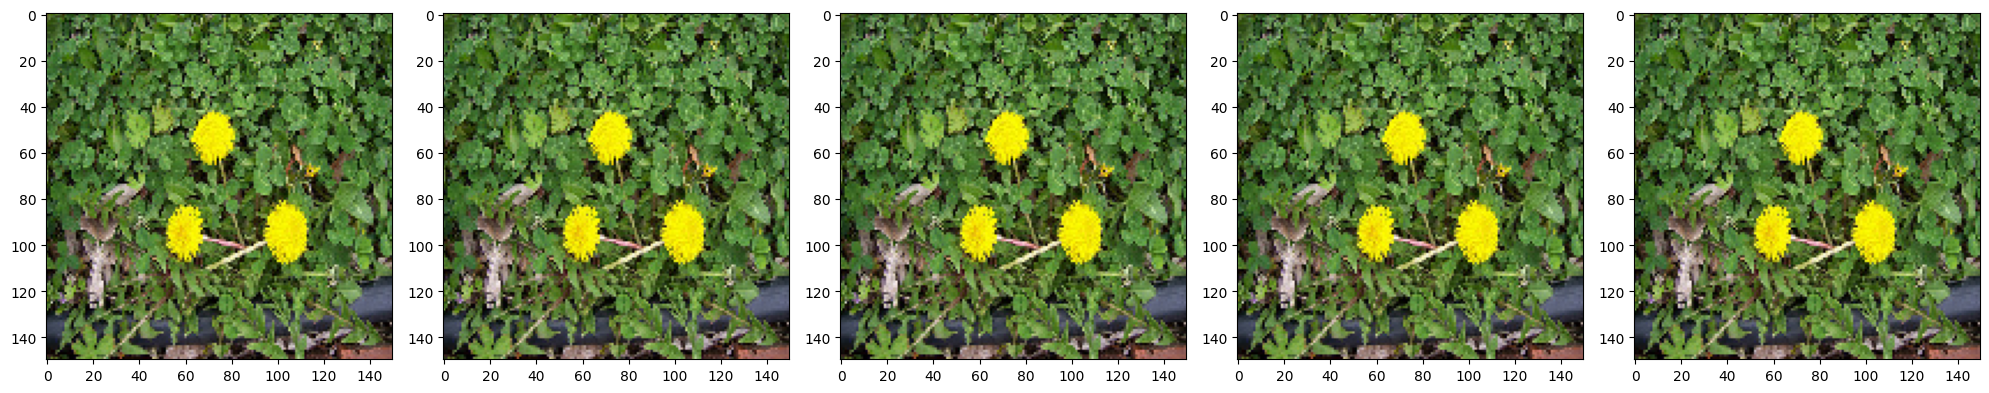

In [ ]:
# Эта функция размещает изображения в сетке с одной строкой и пятью столбцами
# и затем отображает полученную сетку.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


**Что нужно сделать:**

В ячейке ниже используйте `ImageDataGenerator`, чтобы создать преобразование, которое масштабирует изображения делением на 255, а затем применяет случайный поворот на 45 градусов. Затем используйте метод `.flow_from_directory`, чтобы применить вышеуказанное преобразование к изображениям в нашем обучающем наборе. Обязательно укажите размер пакета, путь к каталогу обучающих изображений, целевой размер изображений и перемешщайте изображения.

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')


Found 2935 images belonging to 5 classes.


Давайте возьмем одио изображение из наших обучающих примеров и повторим его пять раз, чтобы можно было увидеть результаты применения модификации этого вида к одному и тому же изображению пять раз случайным образом.

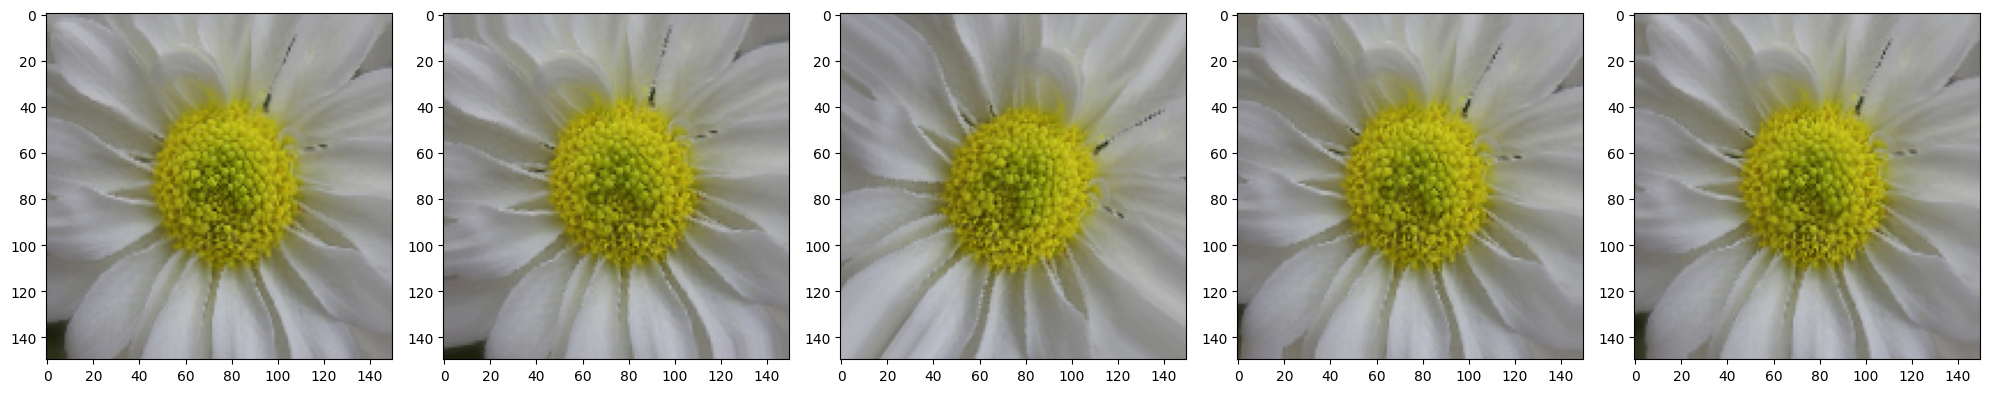

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


**Что нужно сделать:**

В ячейке ниже используйте `ImageDataGenerator`, чтобы создать преобразование которое осуществляет случайное масштабирование изображения до 50%. Затем используйте метод `.flow_from_directory`, чтобы применить вышеуказанное преобразование к изображениям в нашем обучающем наборе. Обязательно укажите размер пакета, путь к каталогу обучающих изображений, целевой размер изображений и перемешайте изображения.

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')

Found 2935 images belonging to 5 classes.


Посмотрите на результат такого преобразования.

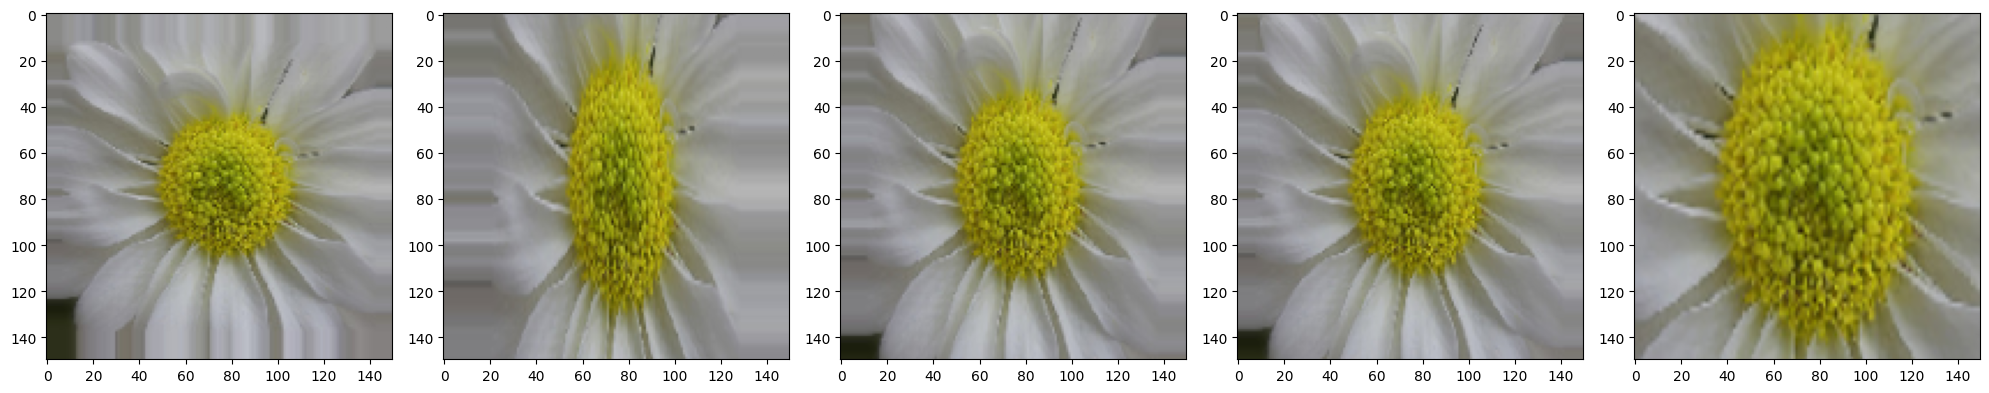

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


**Что нужно сделать:**

Давайте теперь объединим все изученные преобразования в одно. В ячейке ниже используйте `ImageDataGenerator`, чтобы создать преобразование, которое масштабирует изображения и производит:

случайное вращение на 45 градусов

случайный зум до 50%

случайный горизонтальный переворот

сдвиг ширины 0,15

сдвиг высоты 0,15

Затем используйте метод `.flow_from_directory`, чтобы применить вышеуказанное преобразование к изображениям в нашем обучающем наборе. Обязательно укажите размер пакета, путь к каталогу обучающих изображений, целевой размер изображений, перемешайте изображения и установите разреженный режим класса.

In [ ]:
image_gen_train =ImageDataGenerator(rescale=1/255,
                                    zoom_range=0.5,
                                    rotation_range=45,
                                    horizontal_flip=True,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')


Found 2935 images belonging to 5 classes.


Посмотрите как будет выглдядить одно и тоже изображение после применения этих случайных преобразований пять раз.

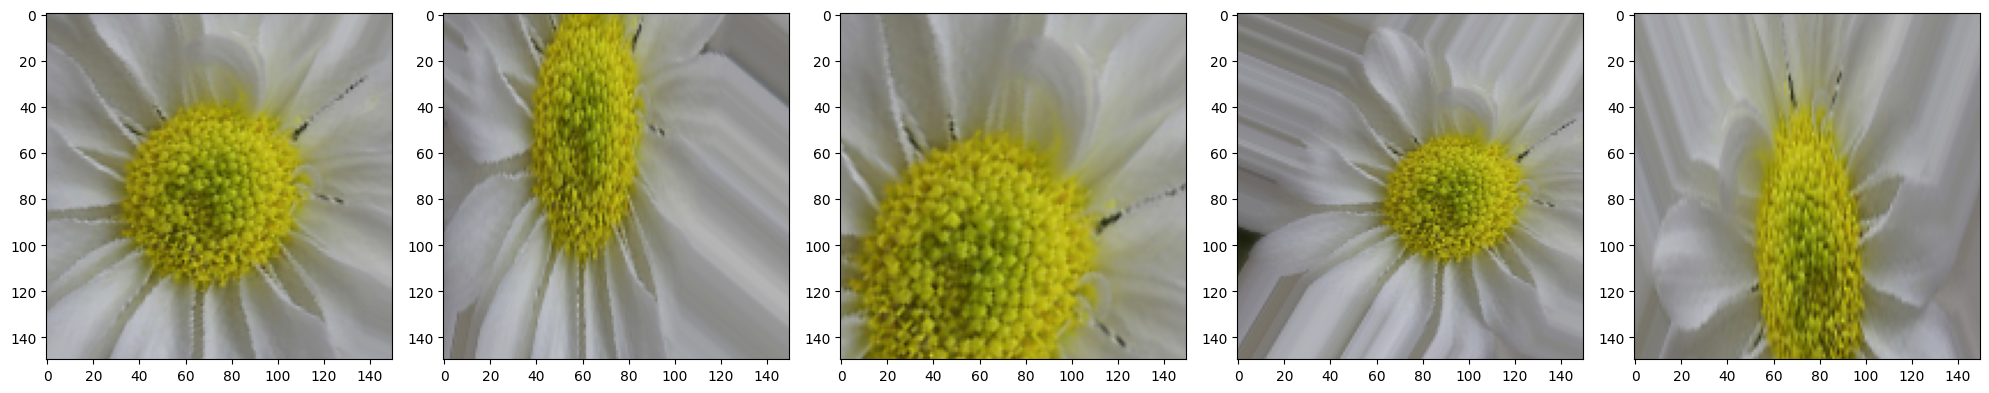

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


**Что нужно сделать:**

В ячейке ниже нужно создать генератор данных для проверки. Обычно модификация данных применяется только при создании обучающих примеров. Поэтому, в ячейке ниже используйте `ImageDataGenerator`, чтобы создать преобразование, которое только масштабирует изображения. Затем используйте метод `.flow_from_directory`, чтобы применить вышеуказанное преобразование к изображениям в нашем наборе проверки. Обязательно укажите размер пакета, путь к каталогу проверочных изображений, целевой размер изображений и установите разреженный режим классов. Помните, что нет необходимости перемешивать изображения в наборе проверки.

In [ ]:
image_gen_val_2 = ImageDataGenerator(validation_split = 0.0,
                                   zoom_range=0.5,
                                     rescale=1/255)
val_data_gen = image_gen_val_2.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')


Found 735 images belonging to 5 classes.


**Что нужно сделать:**

В ячейке ниже создайте сверточную нейронную сеть, состоящую из трех сверточных блоков. Каждый сверточный блок должен содержать слой `Conv2D`, за которым следует слой `Maxpooling2D`. Первый сверточный блок должен иметь 16 фильтров, второй — 32 фильтра, а третий — 64 фильтра. Все сверточные фильтры должны иметь размер (3, 3). Все слои `Maxpooling2D` должны иметь размер ядра (2, 2).
После трех сверточных блоков у вас должен быть сглаженный слой `Flatten`, за которым следует полностью связный слой `Dense` с 512 юнитами. CNN должна возвращать вероятностное распределение на мнодестве меток классов, что достигается использованием функции активации `softmax`. Все остальные уровни должны использовать функцию активации `relu`. Вам также следует добавить слои Dropout с вероятностью 20%, где это возможно.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])


**Что нужно сделать:**

В ячейке ниже скомпилируйте модель, используя оптимизатор ADAM и функцию разреженной перекрестной энтропии в качестве функции потерь. Кроме того, хотелось бы видеть точность обучения и проверки в каждой эпохе обучения сети, с этой целью нужно передать аргумент метрики.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


**Что нужно сделать:**

В ячейке ниже обучите модель, используя функцию `fit_generator` вместо обычной функции подгонки. Здесь необходимо использовать функцию `fit_generator`, поскольку мы используем класс `ImageDataGenerator` для генерации пакетов данных обучения и проверки нашей модели. Обучите модель в течение 80 эпох и убедитесь, что вы используете правильные параметры в функции `fit_generator`.

In [ ]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)


**Что нужно сделать:**

В ячейке ниже постройте графики точности/потери обучения и проверки.

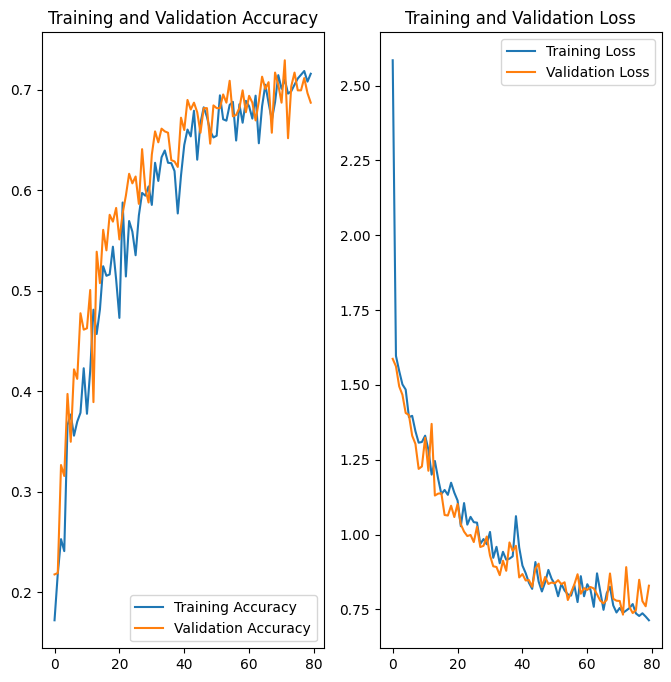

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()



**Что нужно сделать:**

На данный момент вы создали CNN с тремя сверточными слоями и одним плотным слоем содердащим 512 нейронов. В ячейках ниже создайте новую CNN с другой архитектурой. Не стесняйтесь экспериментировать, изменяя столько параметров, сколько захотите. Например, вы можете добавить больше сверточных слоев или больше плотных слоев. Вы также можете поэкспериментировать с разными размерами фильтров в сверточных слоях, разным количеством нейронов в плотных слоях, разными показателями отсева и т. д. Вы можете поэкспериментировать, увеличивая количество изображений с помощью большей номенклатуры преобразований изображений, чем та которую мы использовали до сих пор. Ознакомьтесь с документацией `ImageDataGenerator`, чтобы увидеть полный список всех доступных преобразований изображений. Например, вы можете добавить преобразования сдвига или изменить яркость изображений и т. д. Экспериментируйте как можно больше и сравнивайте точность различных моделей. Какие параметры дают лучший результат?

Работа:

Данные для обучения:
(Добавил параметр для изменения яркости)

In [ ]:
image_gen_train_1 =ImageDataGenerator(rescale=1/255,
                                    zoom_range=0.5,
                                    rotation_range=45,
                                    horizontal_flip=True,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,)
train_data_gen_1 = image_gen_train_1.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')


Found 2935 images belonging to 5 classes.


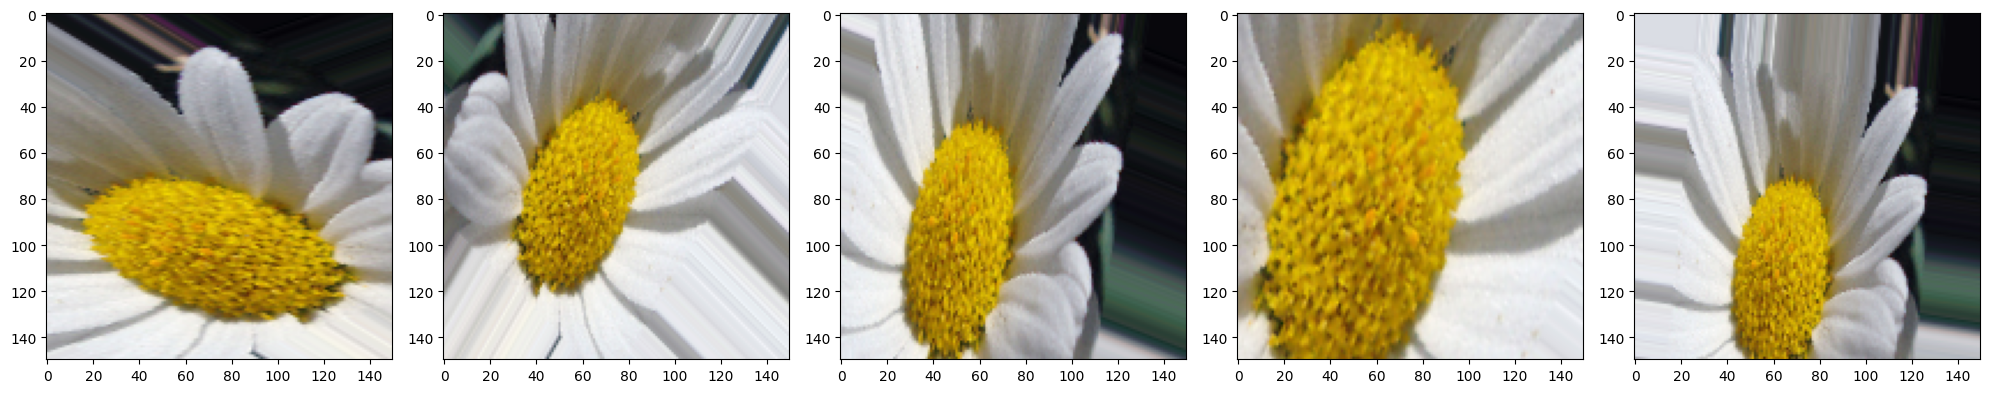

In [ ]:
augmented_images = [train_data_gen_1[0][0][0] for i in range(5)]
plotImages(augmented_images)

Данные для проверки:

In [ ]:
image_gen_val_1 = ImageDataGenerator(validation_split = 0.0,
                                   zoom_range=0.5,
                                     rescale=1/255)
val_data_gen_1 = image_gen_val_1.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='sparse')

Found 735 images belonging to 5 classes.


Добавил 1 сверточный слой.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)       

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Добавил 10 эпох (80 -> 90)

In [ ]:
epochs = 90

history = model.fit_generator(
    train_data_gen_1,
    steps_per_epoch=int(np.ceil(train_data_gen_1.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen_1,
    validation_steps=int(np.ceil(val_data_gen_1.n / float(batch_size)))
)

<ipython-input-25-a776a220a5a7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/90
30/30 [==============================] - 29s 858ms/step - loss: 1.6969 - accuracy: 0.1997 - val_loss: 1.6083 - val_accuracy: 0.2449
Epoch 2/90
30/30 [==============================] - 27s 906ms/step - loss: 1.6090 - accuracy: 0.2446 - val_loss: 1.6073 - val_accuracy: 0.2449
Epoch 3/90
30/30 [==============================] - 26s 885ms/step - loss: 1.6076 - accuracy: 0.2436 - val_loss: 1.6028 - val_accuracy: 0.2476
Epoch 4/90
30/30 [==============================] - 26s 864ms/step - loss: 1.6583 - accuracy: 0.1336 - val_loss: 1.6061 - val_accuracy: 0.2449
Epoch 5/90
30/30 [==============================] - 25s 846ms/step - loss: 1.6078 - accuracy: 0.2446 - val_loss: 1.6034 - val_accuracy: 0.2449
Epoch 6/90
30/30 [==============================] - 26s 875ms/step - loss: 1.6080 - accuracy: 0.2446 - val_loss: 1.5998 - val_accuracy: 0.2449
Epoch 7/90
30/30 [==============================] - 30s 1s/step - loss: 1.5912 - accuracy: 0.2859 - val_loss: 1.5736 - val_accuracy: 0.2599
Ep

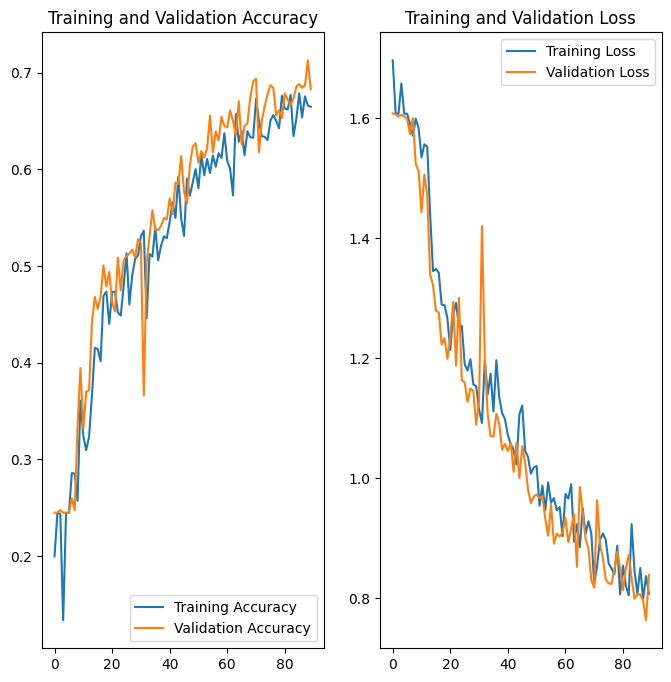

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()


в результате изменений повысилась точность определения )



